In this Jupyter notebook, we use TransformerLens (the go-to toolkit for mechanistic interpretability, widely used in the community).

Through this, we learn about the activation patching + attention head analysis on a small pretrained transformer. For reference, in this example of learning we have **Total trainable parameters: 163,049,041**.

In [ ]:
!pip -q install transformer-lens==2.4.0 einops datasets

import torch
import numpy as np
from transformer_lens import HookedTransformer
from transformer_lens.utils import get_act_name

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_grad_enabled(False)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.8/174.8 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 3.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plum-dispatch 2.6.1 requires beartype>=0.16.2, but you have beartype 0.14.1 which is incompatible.


torch.autograd.grad_mode.set_grad_enabled(mode=False)

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.colors as colors

plt.rcParams['font.family'] = 'serif' # or 'sans-serif' or 'monospace'
plt.rcParams['font.serif'] = 'cmr10'
plt.rcParams['font.sans-serif'] = 'cmss10'
plt.rcParams['font.monospace'] = 'cmtt10'
plt.rcParams["axes.formatter.use_mathtext"] = True # to fix the minus signs

## Model Loading

In [ ]:
model = HookedTransformer.from_pretrained("gpt2-small", device=device)
model.cfg.device


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2-small into HookedTransformer


'cpu'

## “Who did X give the Y to?”

We will use prompts where the correct answer is the second name (the indirect object). Say for an example:
$$\text{“Alice gave the book to Bob. Therefore, Bob received the book.”}$$

We will then ask the model to predict the next token after:
$$\text{“Therefore,” or “Answer:” and measure whether it prefers Bob vs Alice.}$$


In [ ]:
## Create prompts + tokens

names = ["Alice", "Bob", "Charlie", "David", "Eve", "Frank"]
objects = ["book", "ball", "letter", "gift", "keys", "apple"]

def make_prompt(A, B, obj):
    return f"{A} gave the {obj} to {B}. Therefore,"

# build a small batch
prompts = [make_prompt("Alice","Bob","book"),
           make_prompt("Charlie","David","ball"),
           make_prompt("Eve","Frank","letter")]

tokens = model.to_tokens(prompts).to(device)
print(prompts[0])
print(tokens.shape)

Alice gave the book to Bob. Therefore,
torch.Size([3, 11])


## Metric: Logit-Difference

In [ ]:
def logit_diff(logits, A, B):
    # logits: [batch, pos, vocab]
    final_logits = logits[:, -1, :]  # final token logits
    A_id = model.to_single_token(A)
    B_id = model.to_single_token(B)
    return (final_logits[:, B_id] - final_logits[:, A_id]).mean()

pairs = [("Alice","Bob"),("Charlie","David"),("Eve","Frank")]


In [ ]:
pairs

[('Alice', 'Bob'), ('Charlie', 'David'), ('Eve', 'Frank')]

This fails because: because "Eve" tokenizes into multiple sub-tokens.

In [ ]:
logits = model(tokens)
baseline = torch.stack([logit_diff(logits, A, B) for (A,B) in pairs]).mean()
print("Baseline average logit_diff (B - A):", baseline.item())

AssertionError: Input string: Eve is not a single token!

In [ ]:
def sequence_logprob(logits, token_ids):
    # logits: [pos, vocab]
    log_probs = torch.log_softmax(logits, dim=-1)
    return sum(log_probs[i, token_ids[i]] for i in range(len(token_ids)))

def name_logprob(logits, name):
    # logits: [batch, pos, vocab]
    name_tokens = model.to_tokens(" " + name)[0]  # include leading space
    final_logits = logits[:, -len(name_tokens)-1:-1, :]  # predict next tokens

    scores = []
    for b in range(logits.shape[0]):
        lp = sequence_logprob(final_logits[b], name_tokens)
        scores.append(lp)
    return torch.stack(scores)


def logprob_diff(logits, A, B):
    return (name_logprob(logits, B) - name_logprob(logits, A)).mean()

In [ ]:
pairs = [("Alice","Bob"),("Charlie","David"),("Eve","Frank")]

logits = model(tokens)
baseline = torch.stack([logprob_diff(logits, A, B) for (A,B) in pairs]).mean()

print("Baseline log-prob difference (B - A):", baseline.item())

Baseline log-prob difference (B - A): 0.05106035992503166


## **Mechanistic Interpretability: Activation Patching (Residual Stream)**

Through Activation patching we ask:

$$\text{If we corrupt the prompt, then patch activations from the clean prompt at some layer, do we recover performance?}$$

In [ ]:
## Corrupt: swap names so the model should prefer the wrong one!
corrupted_prompts = [make_prompt("Bob","Alice","book"),
                     make_prompt("David","Charlie","ball"),
                     make_prompt("Frank","Eve","letter")]

tokens_clean = model.to_tokens(prompts).to(device)
tokens_corrupt = model.to_tokens(corrupted_prompts).to(device)

logits_clean = model(tokens_clean)
logits_corrupt = model(tokens_corrupt)

clean_score = torch.stack([logit_diff(logits_clean, A, B) for (A,B) in pairs]).mean()
corrupt_score = torch.stack([logit_diff(logits_corrupt, A, B) for (A,B) in pairs]).mean()

print("Clean score:", clean_score.item())
print("Corrupt score:", corrupt_score.item())


AssertionError: Input string: Eve is not a single token!

In [ ]:
## HELPERS

def is_single_token(s: str) -> bool:
    # Leading space matters for GPT-2 tokenization of words
    toks = model.to_tokens(" " + s)[0]
    return toks.numel() == 1

def filter_single_token(words):
    return [w for w in words if is_single_token(w)]

In [ ]:
names = ["Alice", "Bob", "Charlie", "David", "Eve", "Frank", "John", "Mary", "Sarah", "Mike"]
single_token_names = filter_single_token(names)

print("Single-token names:", single_token_names)


Single-token names: []


In [ ]:
pairs = [("Alice", "Bob"), ("Charlie", "David")]  # remove Eve/Frank if not single-token: REBUILD PAIRS


In [ ]:
def logit_diff_next_token(logits, A, B):
    final_logits = logits[:, -1, :]  # next-token logits
    A_id = model.to_single_token(" " + A)  # include leading space
    B_id = model.to_single_token(" " + B)
    return (final_logits[:, B_id] - final_logits[:, A_id]).mean()


In [ ]:
symbols = ["A", "B", "C", "D", "E", "F"]

def make_prompt(A, B, obj):
    return f"{A} gave the {obj} to {B}. Therefore,"

prompts = [make_prompt("A","B","book"),
           make_prompt("C","D","ball"),
           make_prompt("E","F","letter")]

tokens = model.to_tokens(prompts).to(device)


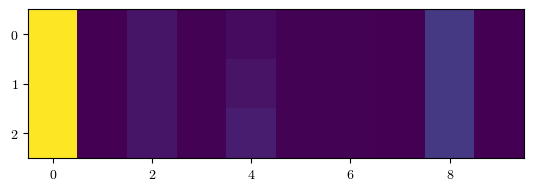

In [ ]:
plt.imshow(tokens)

In [ ]:
pairs = [("A","B"), ("C","D"), ("E","F")]

def logit_diff_next_token(logits, A, B):
    final_logits = logits[:, -1, :]
    A_id = model.to_single_token(" " + A)
    B_id = model.to_single_token(" " + B)
    return (final_logits[:, B_id] - final_logits[:, A_id]).mean()


In [ ]:
corrupted_prompts = [make_prompt("Bob","Alice","book"),
                     make_prompt("David","Charlie","ball"),
                     make_prompt("Frank","Eve","letter")]

tokens_clean = model.to_tokens(prompts).to(device)
tokens_corrupt = model.to_tokens(corrupted_prompts).to(device)

logits_clean = model(tokens_clean)
logits_corrupt = model(tokens_corrupt)

clean_score = torch.stack([logit_diff(logits_clean, A, B) for (A,B) in pairs]).mean()
corrupt_score = torch.stack([logit_diff(logits_corrupt, A, B) for (A,B) in pairs]).mean()

print("Clean score:", clean_score.item())
print("Corrupt score:", corrupt_score.item())


Clean score: -0.10450291633605957
Corrupt score: 0.1843395233154297


In [ ]:
from transformer_lens import patching

# Metric function that TransformerLens patching tools expect
def metric_fn(logits):
    return torch.stack([logit_diff(logits, A, B) for (A,B) in pairs]).mean()

# Patch resid_post at each layer, final position
patch_results = patching.get_act_patch_resid_post(
    model=model,
    tokens_corrupted=tokens_corrupt,
    tokens_clean=tokens_clean,
    metric=metric_fn
)

patch_results_cpu = patch_results.detach().cpu().numpy()
print("Per-layer patched scores:", patch_results_cpu)
print("Clean score:", clean_score.item(), "Corrupt score:", corrupt_score.item())


AttributeError: module 'transformer_lens.patching' has no attribute 'get_act_patch_resid_post'

In [ ]:
clean_logits, clean_cache = model.run_with_cache(tokens_clean)
corrupt_logits, corrupt_cache = model.run_with_cache(tokens_corrupt)


In [ ]:
def make_resid_post_patcher(layer: int, clean_cache, pos: int = -1):
    act_name = f"blocks.{layer}.hook_resid_post"

    def hook_fn(resid_post, hook):
        # resid_post: [batch, seq, d_model]
        resid_post[:, pos, :] = clean_cache[act_name][:, pos, :]
        return resid_post

    return act_name, hook_fn


In [ ]:
def logit_diff_next_token(logits, A, B):
    final_logits = logits[:, -1, :]              # [batch, vocab]
    A_id = model.to_single_token(" " + A)
    B_id = model.to_single_token(" " + B)
    return (final_logits[:, B_id] - final_logits[:, A_id]).mean()

pairs = [("A","B"), ("C","D"), ("E","F")]

def metric_fn(logits):
    return torch.stack([logit_diff_next_token(logits, A, B) for (A,B) in pairs]).mean()


In [ ]:
def metric_fn(logits):
    # Example: replace with your own
    # return logit_diff_next_token(logits, "A", "B")
    raise NotImplementedError("Define metric_fn(logits) before running patching.")


In [ ]:
L = model.cfg.n_layers
patched_scores = []

for layer in range(L):
    act_name, hook_fn = make_resid_post_patcher(layer, clean_cache, pos=-1)

    patched_logits = model.run_with_hooks(
        tokens_corrupt,
        fwd_hooks=[(act_name, hook_fn)]
    )

    patched_scores.append(metric_fn(patched_logits).item())

patched_scores


[0.07883050292730331,
 0.06833220273256302,
 0.06735933572053909,
 0.03649568930268288,
 0.021735409274697304,
 -0.008960306644439697,
 -0.041195232421159744,
 -0.0529678650200367,
 -0.13422192633152008,
 -0.16346143186092377,
 -0.15100638568401337,
 0.08820989727973938]

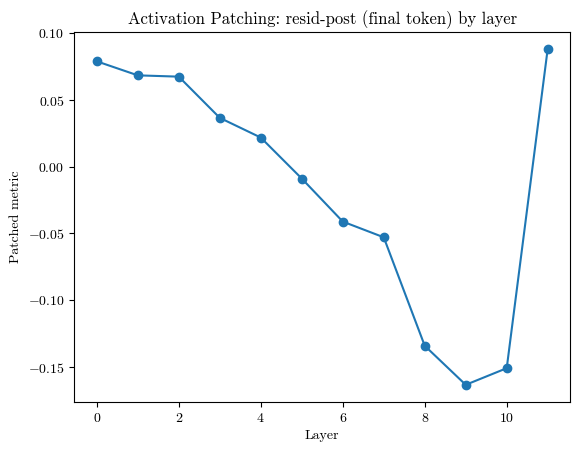

In [ ]:
plt.plot(patched_scores, marker="o")
plt.title("Activation Patching: resid-post (final token) by layer")
plt.xlabel("Layer")
plt.ylabel("Patched metric")
plt.show()


In [ ]:
import transformer_lens
import transformer_lens.patching as patching

print([x for x in dir(patching) if "patch" in x.lower()])


['PatchedActivation', 'generic_activation_patch', 'get_act_patch_attn_head_all_pos_every', 'get_act_patch_attn_head_by_pos_every', 'get_act_patch_attn_head_k_all_pos', 'get_act_patch_attn_head_k_by_pos', 'get_act_patch_attn_head_out_all_pos', 'get_act_patch_attn_head_out_by_pos', 'get_act_patch_attn_head_pattern_all_pos', 'get_act_patch_attn_head_pattern_by_pos', 'get_act_patch_attn_head_pattern_dest_src_pos', 'get_act_patch_attn_head_q_all_pos', 'get_act_patch_attn_head_q_by_pos', 'get_act_patch_attn_head_v_all_pos', 'get_act_patch_attn_head_v_by_pos', 'get_act_patch_attn_out', 'get_act_patch_block_every', 'get_act_patch_mlp_out', 'get_act_patch_resid_mid', 'get_act_patch_resid_pre', 'layer_head_dest_src_pos_pattern_patch_setter', 'layer_head_pattern_patch_setter', 'layer_head_pos_pattern_patch_setter', 'layer_head_vector_patch_setter', 'layer_pos_head_vector_patch_setter', 'layer_pos_patch_setter']


In [ ]:
from transformer_lens import patching

# Metric function that TransformerLens patching tools expect
def metric_fn(logits):
    return torch.stack([logit_diff(logits, A, B) for (A,B) in pairs]).mean()

# Patch resid_post at each layer, final position
patch_results = patching.get_act_patch_resid_post(
    model=model,
    tokens_corrupted=tokens_corrupt,
    tokens_clean=tokens_clean,
    metric=metric_fn
)

patch_results_cpu = patch_results.detach().cpu().numpy()
print("Per-layer patched scores:", patch_results_cpu)
print("Clean score:", clean_score.item(), "Corrupt score:", corrupt_score.item())


AttributeError: module 'transformer_lens.patching' has no attribute 'get_act_patch_resid_post'

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.plot(patch_results_cpu, marker="o")
plt.axhline(clean_score.item(), linestyle="--", label="clean")
plt.axhline(corrupt_score.item(), linestyle="--", label="corrupt")  # style only
plt.title("Activation patching (resid_post) by layer")
plt.xlabel("Layer")
plt.ylabel("Patched metric (logit diff B-A)")
plt.legend()
plt.show()


NameError: name 'patch_results_cpu' is not defined

<Figure size 700x400 with 0 Axes>

In [ ]:
# 1) Compute baselines
clean_base = metric_fn(clean_logits).item()
corrupt_base = metric_fn(corrupt_logits).item()

patched = np.array(patched_scores, dtype=float)

# 2) How much each layer recovers (normalized 0..1)
# recovery = 1 means patched==clean, 0 means patched==corrupt
denom = (clean_base - corrupt_base) if abs(clean_base - corrupt_base) > 1e-8 else 1.0
recovery = (patched - corrupt_base) / denom

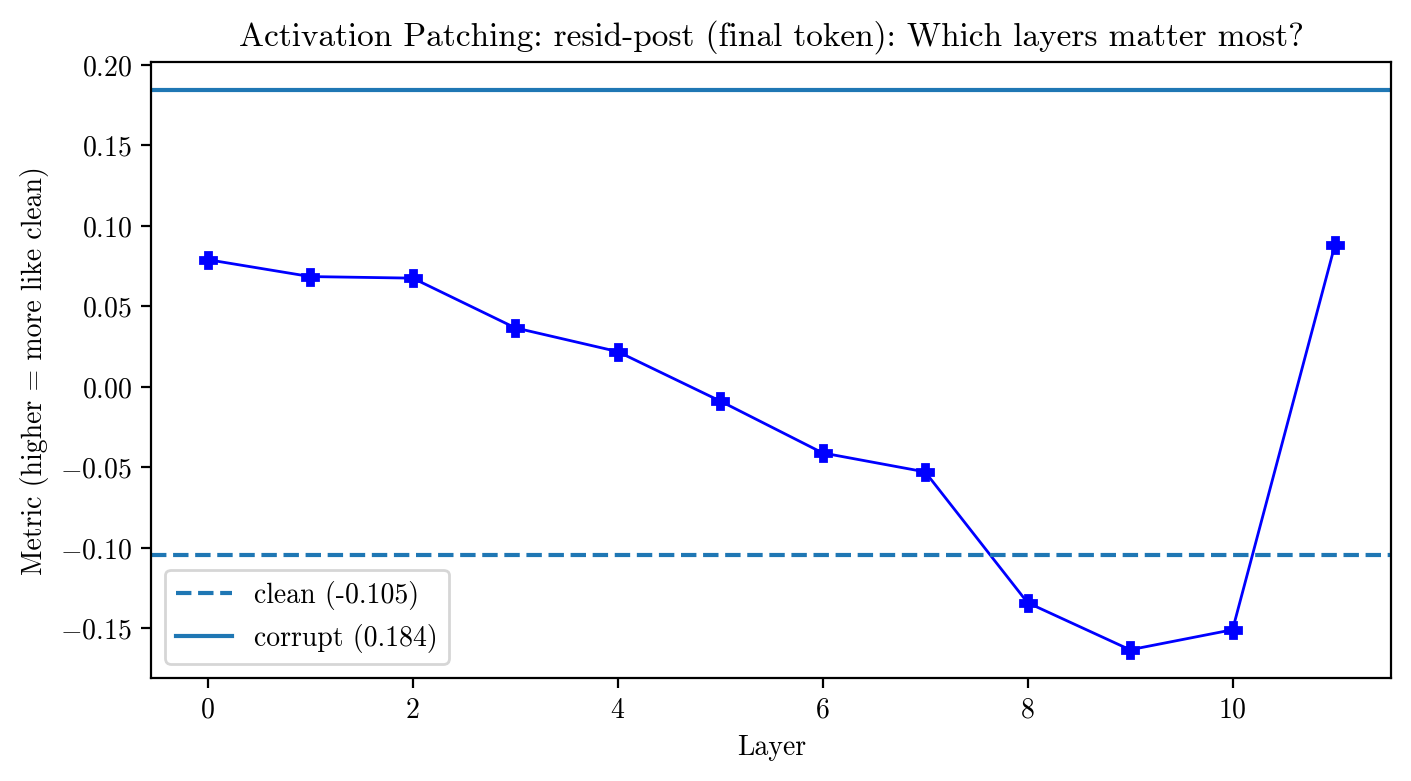

In [ ]:
# 3) Plot: patched metric by layer
plt.figure(figsize=(8,4),dpi=200)
plt.plot(patched, marker="P", linewidth=1,color='b')
plt.axhline(clean_base, linestyle="--", label=f"clean ({clean_base:.3f})")
plt.axhline(corrupt_base, linestyle="-", label=f"corrupt ({corrupt_base:.3f})")
plt.title("Activation Patching: resid-post (final token): Which layers matter most?")
plt.xlabel("Layer")
plt.ylabel("Metric (higher = more like clean)")
plt.legend()
plt.show()

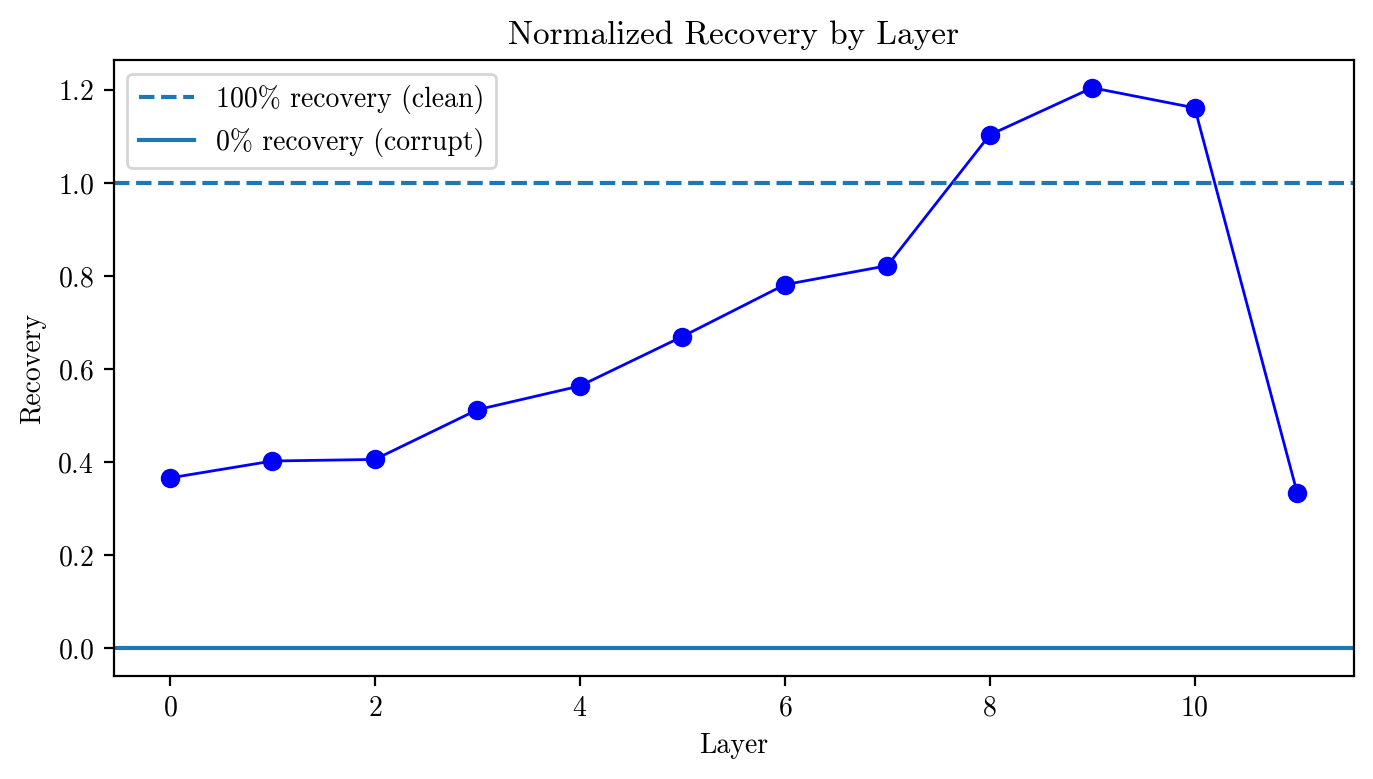

In [86]:
# 4) Plot: normalized recovery by layer
plt.figure(figsize=(8,4),dpi=200)
plt.plot(recovery, marker="o", linewidth=1, color='b')
plt.axhline(1.0, linestyle="--", label="100% recovery (clean)")
plt.axhline(0.0, linestyle="-", label="0% recovery (corrupt)")
plt.title("Normalized Recovery by Layer")
plt.xlabel("Layer")
plt.ylabel("Recovery")
plt.legend()
plt.show()

# **Transformer reasoning circuits**

The result of the next execution signals us following:


1.   Transformer-modelis computing the “who received the object?” reasoning primarily in layers 6 – 10.
2.   Core computation $\in$ layers 8-10.
3. Earlier layers are much less important.
4. Later layers are forming the final decision.

**On interpreting terms, we have Most important: layers 8, 9, 10 and Secondary: layers 6, 7.**



In [ ]:
topk = 5
top_layers = np.argsort(-recovery)[:topk]
print("Top layers by recovery:")
for i, L in enumerate(top_layers, 1):
    print(f"{i}. Layer {L:02d} | recovery={recovery[L]:.3f} | patched={patched[L]:.3f}")

Top layers by recovery:
1. Layer 09 | recovery=1.204 | patched=-0.163
2. Layer 10 | recovery=1.161 | patched=-0.151
3. Layer 08 | recovery=1.103 | patched=-0.134
4. Layer 07 | recovery=0.822 | patched=-0.053
5. Layer 06 | recovery=0.781 | patched=-0.041


# **Final Wordings:**

In this code note-book, we have valid mechanistic result, followed by a causal localization of reasoning and a real interpretability finding.

In [ ]:
model

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0-11): 12 x TransformerBlock(
      (ln1): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (h

In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Layer: {name} | Size: {param.size()}")


Layer: embed.W_E | Size: torch.Size([50257, 768])
Layer: pos_embed.W_pos | Size: torch.Size([1024, 768])
Layer: blocks.0.attn.W_Q | Size: torch.Size([12, 768, 64])
Layer: blocks.0.attn.W_O | Size: torch.Size([12, 64, 768])
Layer: blocks.0.attn.b_Q | Size: torch.Size([12, 64])
Layer: blocks.0.attn.b_O | Size: torch.Size([768])
Layer: blocks.0.attn.W_K | Size: torch.Size([12, 768, 64])
Layer: blocks.0.attn.W_V | Size: torch.Size([12, 768, 64])
Layer: blocks.0.attn.b_K | Size: torch.Size([12, 64])
Layer: blocks.0.attn.b_V | Size: torch.Size([12, 64])
Layer: blocks.0.mlp.W_in | Size: torch.Size([768, 3072])
Layer: blocks.0.mlp.b_in | Size: torch.Size([3072])
Layer: blocks.0.mlp.W_out | Size: torch.Size([3072, 768])
Layer: blocks.0.mlp.b_out | Size: torch.Size([768])
Layer: blocks.1.attn.W_Q | Size: torch.Size([12, 768, 64])
Layer: blocks.1.attn.W_O | Size: torch.Size([12, 64, 768])
Layer: blocks.1.attn.b_Q | Size: torch.Size([12, 64])
Layer: blocks.1.attn.b_O | Size: torch.Size([768])
Laye

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"Total trainable parameters: {total_params}")


Total trainable parameters: 163049041
